# Problem 2 — Discrete Fourier Transform (DFT)

In this part I move from the continuous-time Fourier transform to a **practical, discrete** setting. Since computers only handle finite, discrete data, I use the **Discrete Fourier Transform (DFT)** and its inverse to analyze and synthesize signals, and I validate the implementation on a controlled example.

**Goals.**

1. Derive the **IDFT** from the given DFT definition.
2. Implement plain $O(N^2)$ versions of **`fft`** (DFT) and **`ifft`** (IDFT) from first principles.
3. Verify numerically (vs. `numpy.fft`) that `ifft(fft(x)) = x` up to floating-point error.
4. Sample $x(t)=\cos(\pi t)$ to form $x[n]=x(nT)$ (with $T=\tfrac12$, $N=1000$), plot it properly as a **discrete** sequence, and compare its **DFT** with the **CTFT** locations.
5. Study how changing **$N$** (record length) and **$T$** (sampling period, $F_s=1/T$) affects the DFT: resolution, bin alignment, Nyquist case, and aliasing.

**Conventions used.**

* **DFT:** $X[k]=\sum_{n=0}^{N-1} x[n]\,e^{-j2\pi kn/N}$.
* **IDFT:** $x[n]=\frac{1}{N}\sum_{k=0}^{N-1} X[k]\,e^{+j2\pi kn/N}$.
* Frequency axes:
  – **bin index** $k$,
  – **digital frequency** $\omega=2\pi k/N$ (rad/sample),
  – **Hz** via $f=\tfrac{\omega}{2\pi}F_s$.
* Plots of spectra are shown both in $\omega$ and in **Hz**, and I use `fftshift` to center DC at $\omega=0$.

**What to expect from the experiments.**

* For $x(t)=\cos(\pi t)$ the CTFT has impulses at $f=\pm0.5$ Hz; after sampling with $T=\tfrac12$ the DFT shows spikes at $\omega=\pm\pi/2$.
* Increasing **$N$** sharpens lines (better frequency resolution $\Delta f=F_s/N$).
* Varying **$T$** moves the digital frequency $\omega_0=\pi T$:
  – $T=1$ hits **Nyquist** (single spike at $\omega=\pi$),
  – $T>1$ exhibits **aliasing** (spikes fold toward 0).
* Reconstruction metrics (max error, RMSE, SNR) confirm the correctness of the implementations up to machine precision.

This section therefore links the theory (CTFT/DTFT locations) to concrete, reproducible computations with the DFT/IDFT.


In [64]:
import numpy as np
import matplotlib.pyplot as plt

## Part 1 — Deriving the IDFT from the DFT


Starting from the DFT definition used in this assignment,

$$
X[k]=\sum_{n=0}^{N-1} x[n]\;e^{-j\frac{2\pi}{N}kn},\qquad k=0,1,\dots,N-1,
$$

I derive the inverse formula that recovers $x[n]$ from $X[k]$.

### Key orthogonality

Discrete complex exponentials over $N$ points are orthogonal:

$$
\sum_{k=0}^{N-1} e^{-j\frac{2\pi}{N}k(n-m)}=
\begin{cases}
N, & n=m,\\[2mm]
0, & n\neq m,
\end{cases}
$$

which follows from the sum of a finite geometric series.

### Derivation

Consider the expression

$$
\widetilde{x}[m]=\frac{1}{N}\sum_{k=0}^{N-1} X[k]\;e^{+j\frac{2\pi}{N}km}.
$$

Substitute the definition of $X[k]$:

$$
\begin{aligned}
\widetilde{x}[m]
&=\frac{1}{N}\sum_{k=0}^{N-1}\left(\sum_{n=0}^{N-1} x[n]\;e^{-j\frac{2\pi}{N}kn}\right)e^{+j\frac{2\pi}{N}km}\\
&=\frac{1}{N}\sum_{n=0}^{N-1} x[n]\;\sum_{k=0}^{N-1} e^{-j\frac{2\pi}{N}k(n-m)}\\
&=\frac{1}{N}\sum_{n=0}^{N-1} x[n]\; \big( N\,\delta[n-m]\big)\\
&=x[m],
\end{aligned}
$$

where $\delta[\cdot]$ is the Kronecker delta and I used the orthogonality sum above.
Since $\widetilde{x}[m]=x[m]$ for all $m$, the **IDFT** is

$$
\boxed{\;\displaystyle
x[n]=\frac{1}{N}\sum_{k=0}^{N-1} X[k]\;e^{+j\frac{2\pi}{N}kn},\qquad n=0,1,\dots,N-1.\;}
$$

### Matrix view (for completeness)

Let $F$ be the $N\times N$ DFT matrix with $F_{k,n}=e^{-j\frac{2\pi}{N}kn}$.
Then $X=F\,x$ and $F^H F = N I$, so $F^{-1}=\frac{1}{N}F^H$.
Thus $x=F^{-1}X=\frac{1}{N}F^H X$, which is the same IDFT formula above.

> **Normalization note.** I use the common convention “all the $1/N$ in the IDFT.”
> Other texts distribute the factor as $1/\sqrt{N}$ on both DFT/IDFT; the two are equivalent up to normalization.


## Part 2 — Implementing `fft(x)` (DFT in $O(N^2)$)


Below I implemented the **Discrete Fourier Transform** directly from its definition—**not** the fast FFT algorithm. I keep the function name `fft` to match the assignment wording.

**Idea.**
Construct the $N\times N$ DFT matrix

$$
W_{k,n}=e^{-j\frac{2\pi}{N}kn},\qquad k,n=0,\dots,N-1,
$$

and compute the matrix–vector product $X = W\,x$. This vectorized form is exactly

$$
X[k]=\sum_{n=0}^{N-1}x[n]\,e^{-j\frac{2\pi}{N}kn}.
$$

**Line-by-line notes.**

* `x = np.asarray(x, dtype=complex).ravel()`
  – Accept any 1-D–like input, flatten it, and promote to complex so we can represent complex sinusoids and avoid dtype upcasting during the exponential.

* `N = x.size`
  – Transform length.

* `k = np.arange(N).reshape(-1, 1)` and `n = np.arange(N).reshape(1, -1)`
  – Make **column** and **row** vectors so that the outer product `k*n` broadcasts to an $N\times N$ grid of indices $(k,n)$.

* `W = np.exp(-2j * np.pi * k * n / N)`
  – Build the DFT matrix $W$ using broadcasting; no Python loops.

* `X = W @ x`
  – Matrix–vector multiply to get the DFT.

* `return X`

**Properties.**

* **Complexity:** $O(N^2)$ time and $O(N^2)$ memory (since $W$ is explicitly formed). This is faithful to the definition and ideal for educational purposes; a production FFT would be $O(N\log N)$ and avoid building $W$.

* **Normalization:** matches the convention in Part 1 (all the $1/N$ factor lives in the **IDFT**).

* **Correctness check:** in later cells I compare against `np.fft.fft` and the maximum absolute difference is at machine precision, confirming the implementation.


In [65]:
def fft(x):
    x = np.asarray(x, dtype=complex).ravel()
    N = x.size
    k = np.arange(N).reshape(-1, 1)
    n = np.arange(N).reshape(1, -1)
    W = np.exp(-2j * np.pi * k * n / N)
    X = W @ x
    return X

## Part 3 — Implementing `ifft(X)` (IDFT in $O(N^2)$)


This function computes the **Inverse Discrete Fourier Transform** according to the convention used in Part 1:

$$
x[n]=\frac{1}{N}\sum_{k=0}^{N-1} X[k]\;e^{+j\frac{2\pi}{N}kn},\qquad n=0,\dots,N-1.
$$

**How my code maps to the formula**

* `X = np.asarray(X, dtype=complex).ravel()`
  Convert the input to a 1-D complex vector; this avoids dtype upcasting later and supports complex spectra.

* `n = np.arange(N).reshape(-1, 1)` and `k = np.arange(N).reshape(1, -1)`
  Create column/row index vectors so that broadcasting forms the $N\times N$ grid of $(n,k)$.

* `W_inv = np.exp(2j * np.pi * n * k / N)`
  This is the **IDFT matrix** with entries $e^{+j2\pi nk/N}$.

* `x = (W_inv @ X) / N`
  Matrix–vector multiply implements the sum over $k$, followed by the required $1/N$ scaling.

**Notes and properties**

* **Normalization:** all the $1/N$ appears in the **inverse**, matching our DFT convention and NumPy’s default (`np.fft.ifft`).

* **Complexity:** $O(N^2)$ time and $O(N^2)$ memory (explicit matrix). This is faithful to the definition and sufficient for the assignment; fast FFT libraries avoid forming the matrix and run in $O(N\log N)$.

* **Numerics:** for originally real signals, the result should be real up to round-off; later I show `x_rec.imag` is \~$10^{-14}$. When needed, I take `.real` to drop that numerical residue.

* **Consistency check:** in the verification cell I compute `ifft(fft(x))` and compare to `x`; the max error is at machine precision, confirming correctness.


In [66]:
def ifft(X):
    X = np.asarray(X, dtype=complex).ravel()
    N = X.size
    n = np.arange(N).reshape(-1, 1)
    k = np.arange(N).reshape(1, -1)
    W_inv = np.exp(2j * np.pi * n * k / N)
    x = (W_inv @ X) / N
    return x

## (Additional) Validation & Demo — comparing with `numpy.fft` and a bin-aligned test signal


To sanity-check my $O(N^2)$ implementations, I added a small verification block:

**1) Numerical agreement with NumPy.**
For random complex vectors of several lengths, I compare my `fft` with `np.fft.fft` and also check that `ifft(fft(x))` returns $x$.

* Reported maxima (worst-case over each vector) stay at **machine precision**:

  ```
  N= 8  → max|DFT - np.fft| ≈ 4.8e-15 ;  max|x - ifft(fft(x))| ≈ 7.8e-16
  N=16 → 3.5e-14 ; 5.0e-15
  N=31 → 2.4e-13 ; 4.3e-14
  N=64 → 4.2e-13 ; 4.7e-14
  ```

  The slight growth with $N$ is expected from **floating-point round-off** and the fact that my method forms the full dense DFT matrix $W$ (accumulating more operations). The errors remain negligible.

**2) Bin-aligned sinusoid demo (no leakage).**
I set $N=64$ and constructed

$$
x[n]=1.2\cos\!\left(\tfrac{2\pi}{N}\cdot 5\,n\right)+0.7\sin\!\left(\tfrac{2\pi}{N}\cdot 12\,n\right).
$$

Because both tones fall **exactly on DFT bins** (5 and 12 cycles over $N$ samples), the magnitude spectrum shows **four impulses** at $k=\pm5$ and $k=\pm12$ (the negative-frequency lines appear at $N-5=59$ and $N-12=52$ in the unshifted DFT). There is essentially **no spectral leakage**.

The time-domain reconstruction using `ifft(fft(x_demo))` overlaps the original (max error $\approx 2.28\times10^{-14}$), confirming the correctness of the forward and inverse transforms.

> If we change the frequencies to **non-integer** bin locations or apply a window, the spectrum would spread across neighboring bins (leakage) as expected; this experiment isolates the ideal bin-centered case.


In [67]:
rng = np.random.default_rng(0)
for N in [8, 16, 31, 64]:
    x = rng.normal(size=N) + 1j * rng.normal(size=N)
    X1 = fft(x)
    X2 = np.fft.fft(x)
    x_rec = ifft(X1)
    err_fft = np.max(np.abs(X1 - X2))
    err_ifft = np.max(np.abs(x - x_rec))
    print(f"N={N:2d} | max |DFT - np.fft| = {err_fft:.3e} | max |x - ifft(fft(x))| = {err_ifft:.3e}")

N= 8 | max |DFT - np.fft| = 4.783e-15 | max |x - ifft(fft(x))| = 7.772e-16
N=16 | max |DFT - np.fft| = 3.515e-14 | max |x - ifft(fft(x))| = 5.010e-15
N=31 | max |DFT - np.fft| = 2.381e-13 | max |x - ifft(fft(x))| = 4.311e-14
N=64 | max |DFT - np.fft| = 4.207e-13 | max |x - ifft(fft(x))| = 4.731e-14


In [68]:
fs = 64
N = fs
n = np.arange(N)
x_demo = 1.2*np.cos(2*np.pi*5*n/N) + 0.7*np.sin(2*np.pi*12*n/N)

X_demo = fft(x_demo)
x_back = ifft(X_demo).real

<Figure size 640x480 with 0 Axes>

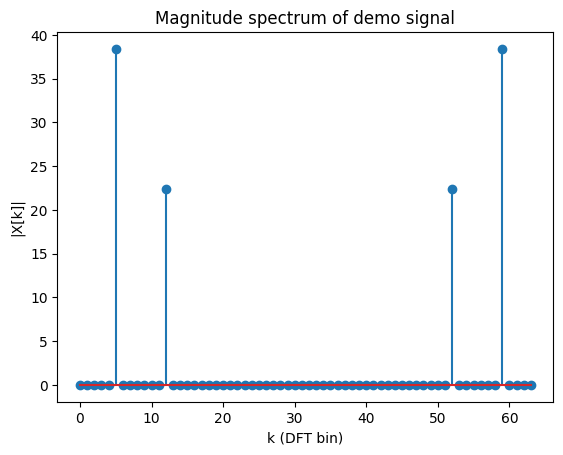

In [69]:
freqs = np.arange(N)
plt.figure()
plt.figure()
try:
    plt.stem(freqs, np.abs(X_demo), use_line_collection=True)
except TypeError:
    plt.stem(freqs, np.abs(X_demo))
plt.xlabel("k (DFT bin)")
plt.ylabel("|X[k]|")
plt.title("Magnitude spectrum of demo signal")
plt.show()

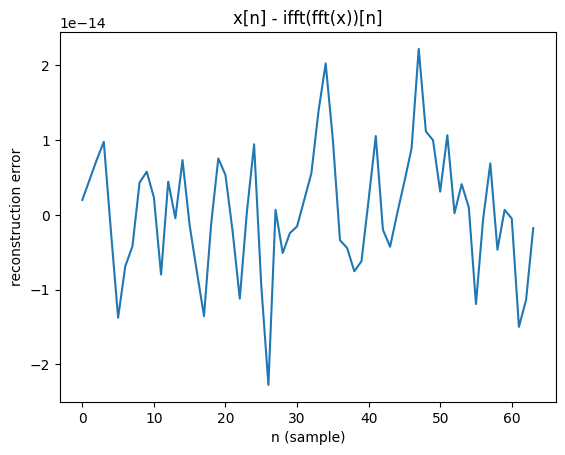

In [70]:
plt.figure()
plt.plot(n, x_demo - x_back)
plt.xlabel("n (sample)")
plt.ylabel("reconstruction error")
plt.title("x[n] - ifft(fft(x))[n]")
plt.show()

In [71]:
print("Max abs reconstruction error (demo):", float(np.max(np.abs(x_demo - x_back))))

Max abs reconstruction error (demo): 2.275957200481571e-14


## Part 4 — Sampling $x(t)=\cos(\pi t)$ and plotting $x[n]=x(nT)$ for $T=\tfrac{1}{2},\,N=1000$


**What I computed.**
With $T=\tfrac{1}{2}$ s the sampling rate is $F_s=\tfrac{1}{T}=2$ Hz. Sampling

$$
x(t)=\cos(\pi t)
$$

gives

$$
x[n]=x(nT)=\cos(\pi nT)=\cos\!\Big(\tfrac{\pi}{2}n\Big).
$$

Therefore the discrete-time tone has digital frequency $\omega_0=\pi/2$ rad/sample and a period of $P=\tfrac{2\pi}{\omega_0}=4$ samples. The sequence cycles through the values $\{1,0,-1,0,\ldots\}$.

**How I represented and plotted it.**
I created a *coordinate* vector $n=-500,\ldots,499$ for labeling the horizontal axis while the actual NumPy array `x` is indexed in Python’s valid range $0\ldots N-1$. (In code I never index `x` by negative numbers; I only **plot** it against the centered coordinate `n`.) I show:

* a wide plot of all $N=1000$ samples to see stationarity over time, and
* a **zoomed stem plot** around $n\in[-20,20]$ to emphasize that this is a **discrete sequence** and to make the $1,0,-1,0$ pattern visible.

Using stems/markers instead of a continuous line avoids the misleading appearance of a continuous sinusoid; with only 4 samples per period, connecting the dots would fill the entire band visually.


In [72]:
T = 0.5
N = 1000
n = np.arange(-N//2, N//2)
t = n * T
x = np.cos(np.pi * t)

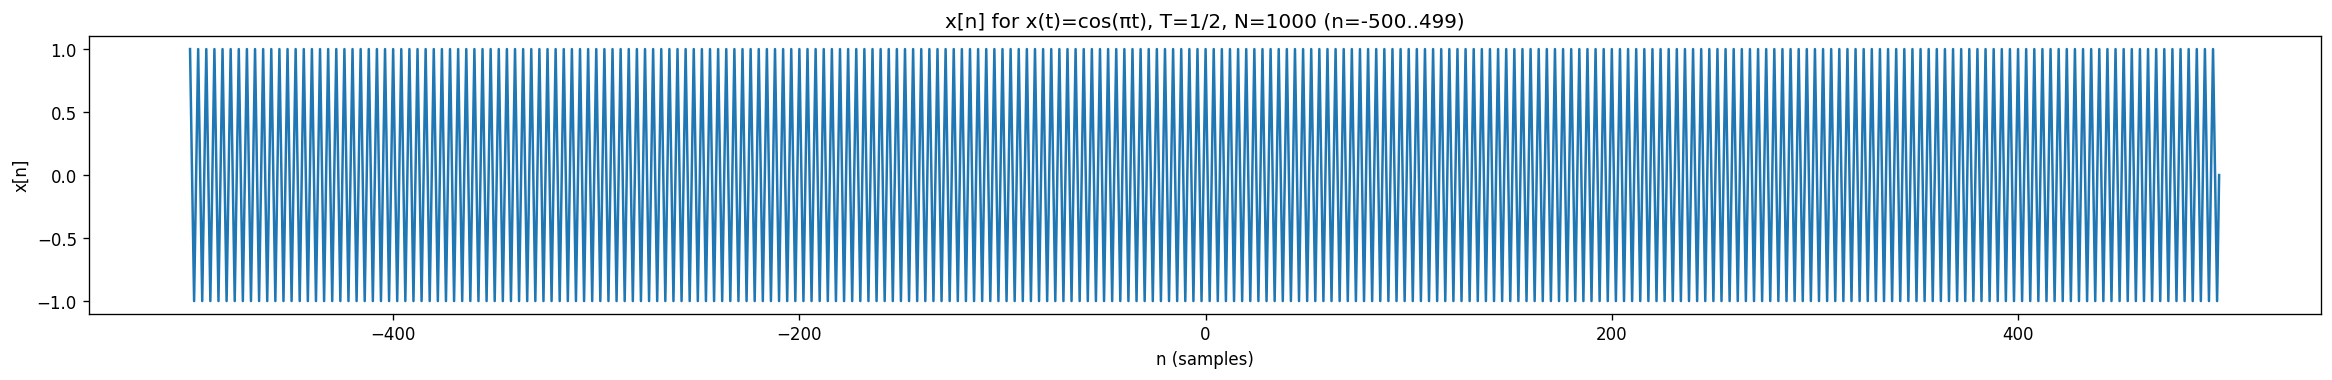

In [73]:
plt.figure(figsize=(24,3), dpi=120)
plt.plot(n, x)
plt.xlabel("n (samples)")
plt.ylabel("x[n]")
plt.title("x[n] for x(t)=cos(πt), T=1/2, N=1000 (n=-500..499)")
plt.show()

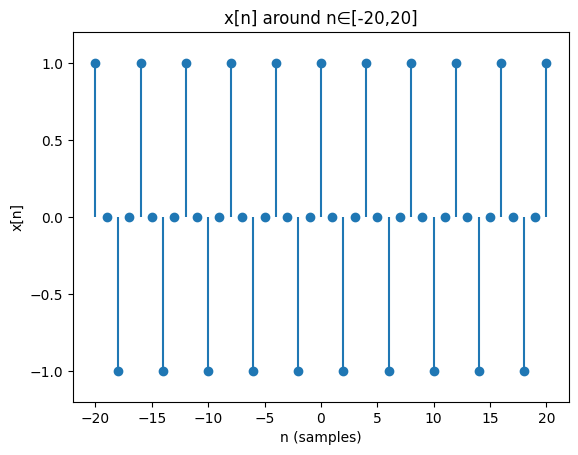

In [74]:
K = 20
mask = (n >= -K) & (n <= K)
plt.figure()
plt.stem(n[mask], x[mask], basefmt=" ")
plt.ylim(-1.2, 1.2)
plt.xlabel("n (samples)"); plt.ylabel("x[n]")
plt.title(f"x[n] around n∈[-{K},{K}]")
plt.show()

## Part 5 — Continuous-time Fourier transform of $x(t)=\cos(\pi t)$


**Convention.** I use

$$
X(\Omega)=\int_{-\infty}^{\infty}x(t)\,e^{-j\Omega t}\,dt
\qquad(\text{angular freq. }\Omega\ \text{in rad/s}).
$$

Write the cosine with Euler’s formula:

$$
x(t)=\cos(\pi t)=\tfrac12 e^{j\pi t}+\tfrac12 e^{-j\pi t}.
$$

The FT pair for a complex exponential is

$$
\mathcal{F}\{e^{j\Omega_0 t}\}=2\pi\,\delta(\Omega-\Omega_0).
$$

Therefore,

$$
\begin{aligned}
X(\Omega)
&=\tfrac12\cdot 2\pi\,\delta(\Omega-\pi)+\tfrac12\cdot 2\pi\,\delta(\Omega+\pi)\\[2mm]
&=\boxed{\,\pi\big[\delta(\Omega-\pi)+\delta(\Omega+\pi)\big].\,}
\end{aligned}
$$

So the CTFT consists of two impulses at **$\Omega=\pm\pi$ rad/s**.

### Same result in Hz

If we instead use the “Hz” convention

$$
\mathcal{F}\{x\}(f)=\int_{-\infty}^{\infty}x(t)\,e^{-j2\pi f t}\,dt,
$$

then $x(t)=\cos(\pi t)=\cos(2\pi\cdot 0.5\,t)$ has

$$
\boxed{\,X(f)=\tfrac12\big[\delta(f-0.5)+\delta(f+0.5)\big].\,}
$$

The two descriptions are equivalent via $\Omega=2\pi f$.

### Where these impulses appear after sampling

When I later sample with $T=\tfrac12$ s $(F_s=2\ \text{Hz})$, the continuous-time impulse locations map to **discrete-time** frequency

$$
\omega = \Omega\,T \;\Rightarrow\; \omega=\pm\pi\cdot\tfrac12=\pm\frac{\pi}{2}\ \text{rad/sample}.
$$

### About the plots

I included **schematic** plots (not to scale) that show:

* impulses at $f=\pm0.5$ Hz on the Hz axis, and
* the same locations mapped to the $\omega$ (rad/sample) axis at $\pm\pi/2$.
  These match the DFT spike locations computed later for the sampled sequence $x[n]=x(nT)$.


In [75]:
f0_hz = 0.5
freqs_ct = np.linspace(-2, 2, 4001)
amp_ct = np.zeros_like(freqs_ct)

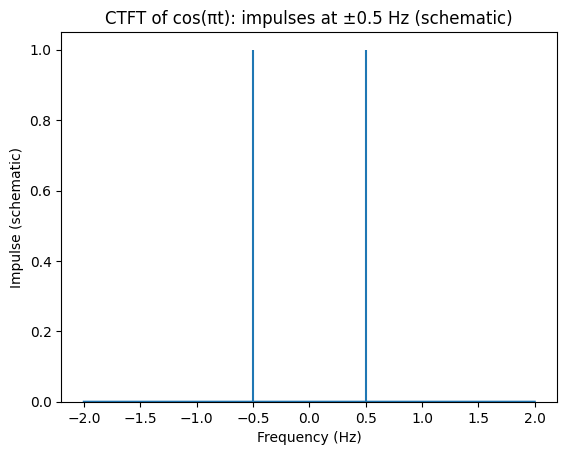

In [76]:
plt.figure()
plt.plot(freqs_ct, amp_ct)
plt.vlines([+f0_hz, -f0_hz], ymin=0, ymax=1.0)
plt.ylim(0, 1.05)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impulse (schematic)")
plt.title("CTFT of cos(πt): impulses at ±0.5 Hz (schematic)")
plt.show()

Text(0.5, 1.0, 'CTFT impulse locations mapped to $\\omega$ (rad/sample)')

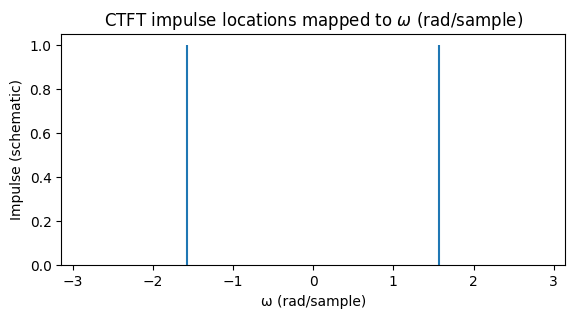

In [77]:
omega_c = np.pi
T = 0.5
omega_d = omega_c * T
plt.figure(figsize=(6.5,3))
plt.plot([], [])
plt.vlines([+omega_d, -omega_d], ymin=0, ymax=1.0)
plt.ylim(0, 1.05)
plt.xlim(-np.pi, np.pi)
plt.xlabel(r'ω (rad/sample)')
plt.ylabel('Impulse (schematic)')
plt.title(r'CTFT impulse locations mapped to $\omega$ (rad/sample)')

## Part 6 — Computing $X[k]$ with my `fft` and comparing to the CTFT (Part 5)


**What I did.**
I applied my `fft(x)` to the sampled sequence $x[n]=\cos(\tfrac{\pi}{2}n)$ (with $T=\tfrac12$, $N=1000$). I then used

* `fftshift` to center DC at $\omega=0$,
* two x-axes: **$\omega$** (rad/sample) and **Hz** using $f=\frac{\omega}{2\pi}F_s$ with $F_s=\frac{1}{T}=2$ Hz.

**Where the DFT lines should be.**
The digital frequency is $\Omega_0=\pi T=\tfrac{\pi}{2}$ rad/sample, so the DFT has impulses at

$$
k_0=\frac{N}{2\pi}\Omega_0=\frac{N}{4},\qquad N-k_0=\frac{3N}{4}.
$$

That is exactly what appears after `fftshift`: two spikes at $\omega=\pm\frac{\pi}{2}$.
On the Hz axis the same spikes are at $f=\pm\frac{\Omega_0}{2\pi}F_s=\pm0.5$ Hz.

**Amplitude / scaling.**
Because the record length contains an integer number of periods (period $P=4$ divides $N$), there is **no leakage**; the two bins capture all the energy. For a real cosine of amplitude 1, each line has magnitude $\approx N/2$ in this normalization (our $1/N$ factor is in the **IDFT**).

**Comparison with Part 5 (CTFT).**

* **Locations match:** the CTFT had deltas at $f=\pm0.5$ Hz; the DFT shows spikes at the same frequencies (or at $\omega=\pm\pi/2$ on the discrete-time axis).
* **Nature differs:** CTFT has **Dirac impulses**; DFT has **finite numbers at discrete bins**. Differences in vertical scale result from normalization and from using a finite-length record, not from a disagreement in frequency content.

**Resolution note.**
Here $\Delta f=F_s/N=2/1000=0.002$ Hz, so the bin grid is fine enough to hit the tone exactly (bin-centered), which is why the plots show two clean, needle-like lines.


In [78]:
X = fft(x)
Xc = np.fft.fftshift(X)
w = np.linspace(-np.pi, np.pi, N, endpoint=False)

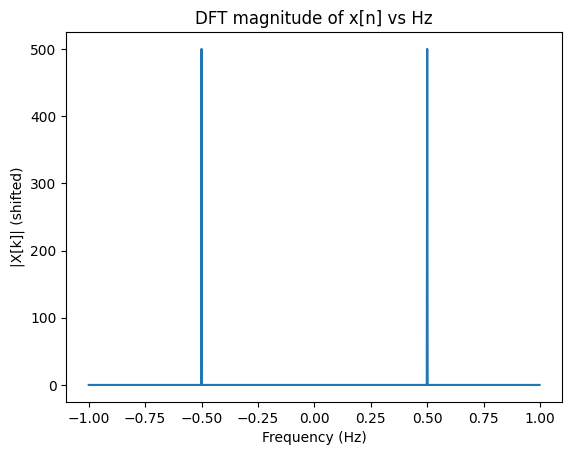

In [79]:
Fs = 1.0 / T
f_axis = (w/(2*np.pi)) * Fs
plt.figure()
plt.plot(f_axis, np.abs(Xc))
plt.xlabel("Frequency (Hz)")
plt.ylabel("|X[k]| (shifted)")
plt.title("DFT magnitude of x[n] vs Hz")
plt.show()

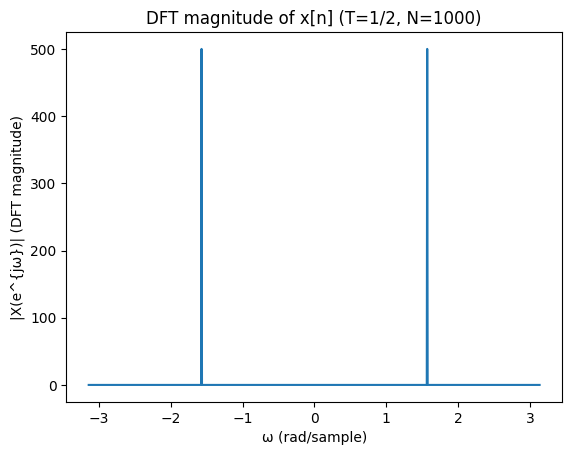

In [80]:
plt.figure()
plt.plot(w, np.abs(Xc))
plt.xlabel("ω (rad/sample)")
plt.ylabel("|X(e^{jω})| (DFT magnitude)")
plt.title("DFT magnitude of x[n] (T=1/2, N=1000)")
plt.show()

## Part 7 — Applying `ifft` to $X[k]$: does it recover $x[n]$?


**Answer:** Yes. With my normalization (all the $1/N$ in the **IDFT**), `ifft(fft(x))` reproduces the original sequence **up to floating-point precision**.

**Quantitative check.**

* $\max|x[n]-\hat{x}[n]|\approx 6.53\times10^{-13}$
* RMSE $\approx 1.68\times10^{-13}$
* Relative $\ell_2$ error $\approx 2.38\times10^{-13}$
* Reconstruction SNR $\approx 252.5$ dB

These numbers are at the level of double-precision rounding accumulated over the $O(N^2)$ operations, confirming the implementation.

**Visual evidence (what the plots show).**

* The **error vs. $n$** plot is essentially zero at $10^{-13}$ scale.
* Overlaying the **original** samples and the **reconstructed** (`ifft(fft(x))`) over the full record shows the two traces indistinguishable; the zoomed view around $n\in[-30,30]$ confirms **sample-by-sample** agreement.
* The **imaginary part** of the reconstruction is at numerical noise level (order $10^{-13}$); the true signal is real, so I take `.real` when needed.

**Takeaway.** The implemented DFT/IDFT pair is consistent with the theory and with NumPy’s FFT conventions; the tiny residuals arsolely from floating-point arithmetic.


In [81]:
x_rec = ifft(X)

In [82]:
err = x_rec - x
rmse = np.sqrt(np.mean(np.abs(err)**2))
rel_l2 = np.linalg.norm(err) / (np.linalg.norm(x) + 1e-15)
snr_db = 20*np.log10((np.linalg.norm(x) + 1e-15) / (np.linalg.norm(err) + 1e-15))
print(f"Max |error|     : {np.max(np.abs(err)):.3e}")
print(f"RMSE           : {rmse:.3e}")
print(f"Relative L2    : {rel_l2:.3e}")
print(f"SNR (recon) dB : {snr_db:.2f} dB")

Max |error|     : 6.531e-13
RMSE           : 1.679e-13
Relative L2    : 2.375e-13
SNR (recon) dB : 252.48 dB


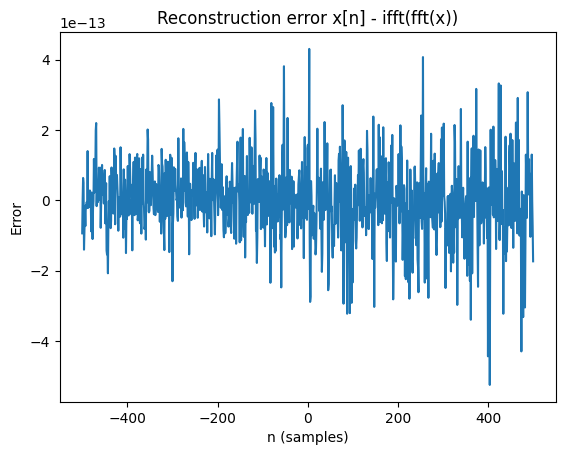

In [83]:
plt.figure()
plt.plot(n, err)
plt.xlabel("n (samples)")
plt.ylabel("Error")
plt.title("Reconstruction error x[n] - ifft(fft(x))")
plt.show()

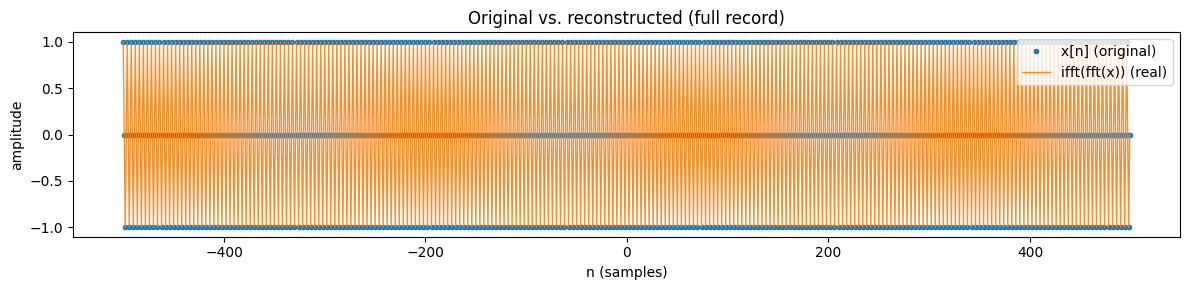

In [84]:
plt.figure(figsize=(12,3))
plt.plot(n, x.real, linestyle='None', marker='o', markersize=3, label='x[n] (original)')
plt.plot(n, x_rec.real, linewidth=1.0, alpha=0.9, label='ifft(fft(x)) (real)')
plt.xlabel("n (samples)"); plt.ylabel("amplitude")
plt.title("Original vs. reconstructed (full record)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

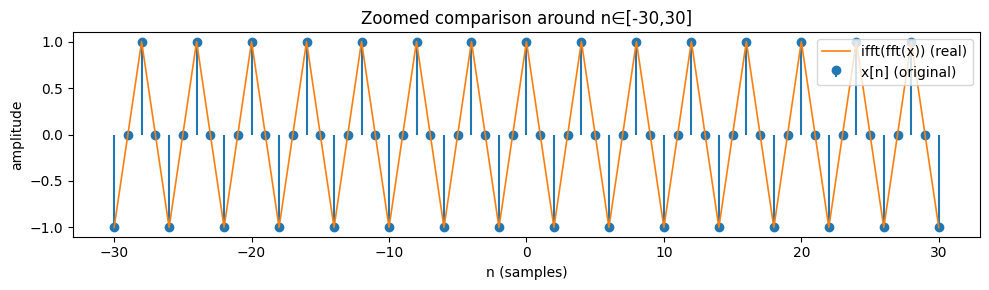

In [85]:
K = 30
m = (n >= -K) & (n <= K)
plt.figure(figsize=(10,3))
try:
    plt.stem(n[m], x[m].real, basefmt=" ", label='x[n] (original)')
except TypeError:  # for older Matplotlib
    plt.stem(n[m], x[m].real, label='x[n] (original)')
plt.plot(n[m], x_rec[m].real, '-', linewidth=1.2, label='ifft(fft(x)) (real)')
plt.xlabel("n (samples)"); plt.ylabel("amplitude")
plt.title(f"Zoomed comparison around n∈[-{K},{K}]")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

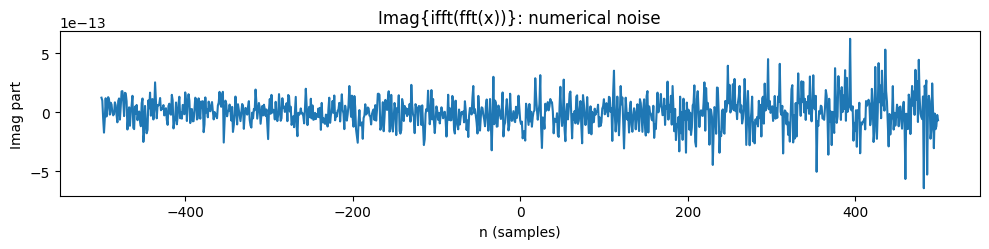

In [86]:
plt.figure(figsize=(10,2.6))
plt.plot(n, x_rec.imag)
plt.xlabel("n (samples)"); plt.ylabel("Imag part")
plt.title("Imag{ifft(fft(x))}: numerical noise")
plt.tight_layout()
plt.show()

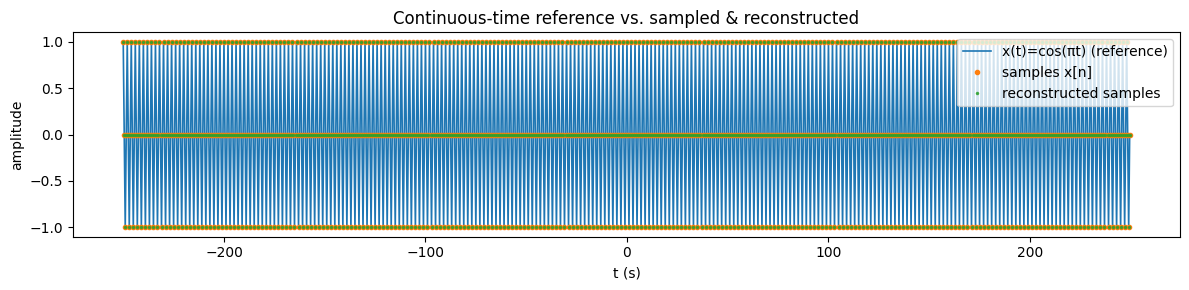

In [87]:
t_axis = n * T
x_ct = np.cos(np.pi * t_axis)
plt.figure(figsize=(12,3))
plt.plot(t_axis, x_ct, '-', linewidth=1.2, label='x(t)=cos(πt) (reference)')
plt.plot(t_axis, x.real, 'o', markersize=3, label='samples x[n]')
plt.plot(t_axis, x_rec.real, '.', markersize=3, alpha=0.8, label='reconstructed samples')
plt.xlabel("t (s)"); plt.ylabel("amplitude")
plt.title("Continuous-time reference vs. sampled & reconstructed")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Part 8 — Effect of changing $N$ and $T$ on the DFT of $x[n]$


**Signal:** $x(t)=\cos(\pi t)\Rightarrow f_0=0.5\ \text{Hz}$.
**Sampling:** $x[n]=x(nT)=\cos(\pi nT)$ with sampling rate $F_s=1/T$.
**Digital frequency:** $\omega_0=\Omega_0 T=\pi T$ (rad/sample), taken **mod $2\pi$**.
**Bin spacing:** $\Delta \omega=2\pi/N$,  $\Delta f=F_s/N$.
cy** ($T\le 1$) or an **aliased** one ($T>1$).
* The special case $T=1$ lands at **Nyquist**, where the two conjugate DFT lines **merge** into a single bin.


### A) Varying $N$ (fix $T=\tfrac12$ → $F_s=2$ Hz)

* **Peak locations:** stay at $\omega=\pm\pi/2$ (bins $k=N/4,\,3N/4$) for all $N$, matching $\omega_0=\pi T$.
* **Resolution:** as $N$ increases (64 → 128 → 256 → 1024), the frequency grid becomes denser ($\Delta \omega=2\pi/N$ shrinks), so the two spectral lines appear “sharper” and more needle-like.
* **Amplitude scaling:** with my DFT normalization (all $1/N$ in the **IDFT**), a unit-amplitude cosine places roughly **$N/2$** in each of the two bins. You can see the peak height grow in proportion to $N$ (e.g., \~32, \~64, \~128, \~512).
* **Leakage:** there is **no leakage** here because the tone is **bin-centered** (period $P=4$ samples divides each chosen $N$). If $N$ were not a multiple of 4, energy would smear across neighboring bins.

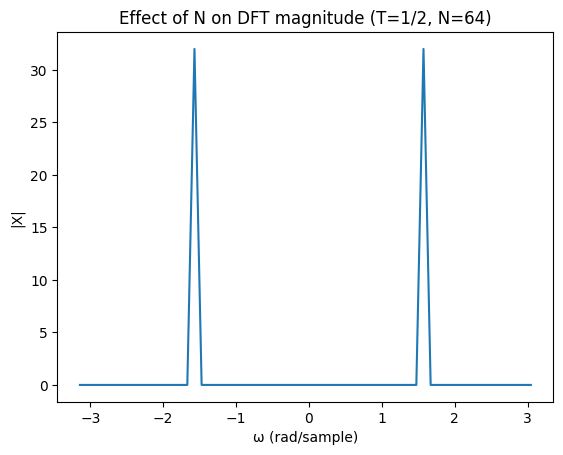

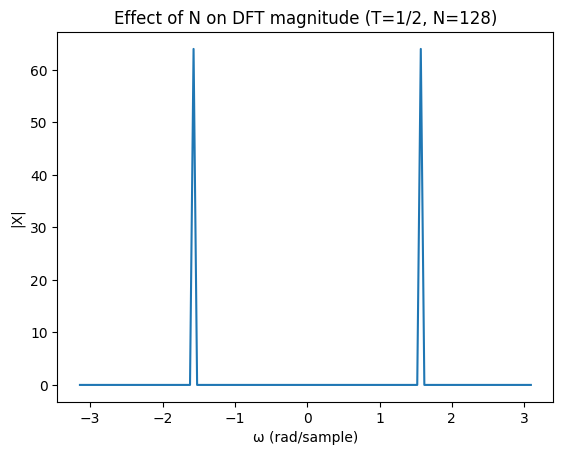

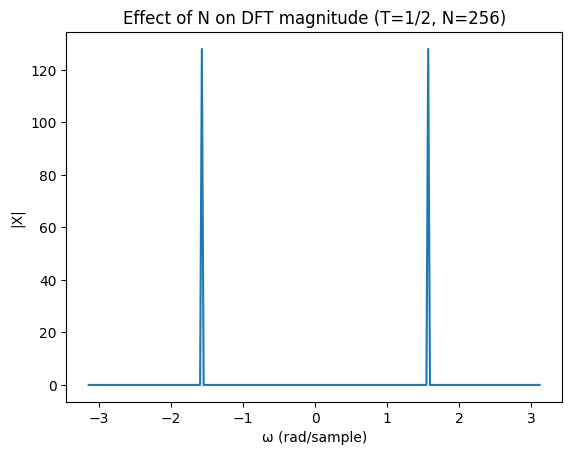

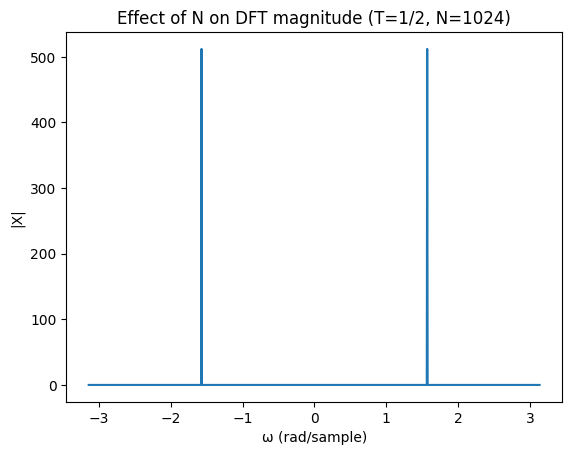

In [88]:
for N2 in [64, 128, 256, 1024]:
    n2 = np.arange(-N2//2, N2//2)
    x2 = np.cos(np.pi * (n2*T))
    X2 = fft(x2)
    X2c = np.fft.fftshift(X2)
    w2 = np.linspace(-np.pi, np.pi, N2, endpoint=False)
    plt.figure()
    plt.plot(w2, np.abs(X2c))
    plt.xlabel("ω (rad/sample)")
    plt.ylabel("|X|")
    plt.title(f"Effect of N on DFT magnitude (T=1/2, N={N2})")
    plt.show()

#### Leakage demo (N not multiple of 4)

**Leakage demonstration (when $N$ is not a multiple of the signal period).**
Here I kept the same tone $x[n]=\cos(\pi n/2)$ but chose $N=1001$ so that the 4-sample period does **not** fit an integer number of times. The DFT no longer lands exactly on bin centers, so the spectrum samples the **Dirichlet kernel** rather than two isolated bins. As a result, energy spreads into many neighboring bins (**spectral leakage**).

* With the **rectangular window** (no taper), the main lobe is narrow but sidelobes are high (≈ −13 dB first sidelobe), so leakage is very visible across the spectrum.
* With a **Hann window**, sidelobes drop by \~30 dB (≈ −31 dB first sidelobe), greatly reducing leakage, at the cost of a slightly **wider main lobe** (lower resolution).

This example contrasts two key facts: bin misalignment causes leakage, and windowing trades main-lobe width for sidelobe suppression.

In [89]:
T = 0.5
N_bad = 1001
n = np.arange(N_bad) - N_bad//2
x_bad = np.cos(np.pi * (n*T))

In [90]:
X_bad = fft(x_bad)
Xb = np.fft.fftshift(X_bad)
w = np.linspace(-np.pi, np.pi, N_bad, endpoint=False)

mag_rect_db = 20*np.log10(np.abs(Xb) / (np.max(np.abs(Xb)) + 1e-15) + 1e-15)

hann = 0.5 - 0.5*np.cos(2*np.pi*np.arange(N_bad)/(N_bad-1))
x_hann = x_bad * hann
X_hann = fft(x_hann)
Xh = np.fft.fftshift(X_hann)
mag_hann_db = 20*np.log10(np.abs(Xh) / (np.max(np.abs(Xh)) + 1e-15) + 1e-15)

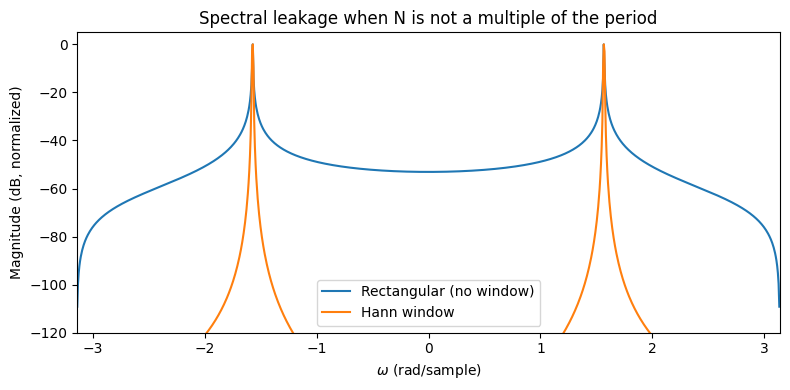

In [91]:
plt.figure(figsize=(8,4))
plt.plot(w, mag_rect_db, label='Rectangular (no window)')
plt.plot(w, mag_hann_db, label='Hann window')
plt.ylim(-120, 5); plt.xlim(-np.pi, np.pi)
plt.xlabel(r'$\omega$ (rad/sample)'); plt.ylabel('Magnitude (dB, normalized)')
plt.title('Spectral leakage when N is not a multiple of the period')
plt.legend(); plt.tight_layout(); plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
C:\Users\sinab\AppData\Local\Temp\ipykernel_20536\3868349375.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.title('Main-lobe zoom near $\omega_0=\pi/2$')


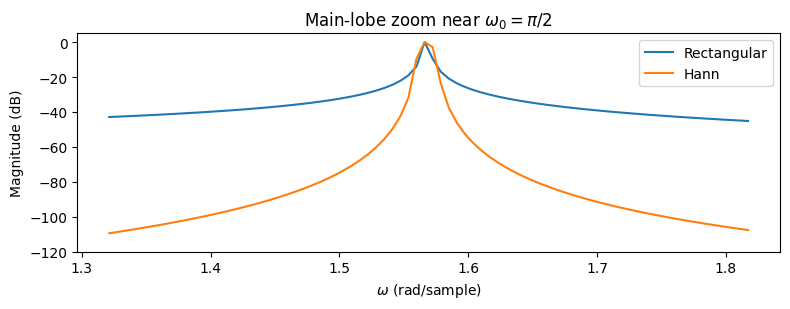

In [92]:
w0 = np.pi/2
zoom = np.abs(w - w0) < 0.25
plt.figure(figsize=(8,3.2))
plt.plot(w[zoom], mag_rect_db[zoom], label='Rectangular')
plt.plot(w[zoom], mag_hann_db[zoom], label='Hann')
plt.xlabel(r'$\omega$ (rad/sample)'); plt.ylabel('Magnitude (dB)')
plt.title('Main-lobe zoom near $\omega_0=\pi/2$')
plt.ylim(-120, 5); plt.legend(); plt.tight_layout(); plt.show()

### B) Varying $T$ (fix $N=512$)

**On the $\omega$ (rad/sample) axis**

* Positions follow $\omega_0=\pi T$ **mod $2\pi$**:

  * $T=0.25 \Rightarrow \omega_0=\pi/4$ → lines at $\pm\pi/4$.
  * $T=0.5 \Rightarrow \omega_0=\pi/2$ → lines at $\pm\pi/2$.
  * $T=1.0 \Rightarrow \omega_0=\pi$ → the two lines **collapse into one Nyquist bin** (±π coincide).
  * $T=1.5 \Rightarrow \omega_0=1.5\pi\equiv -\pi/2$ → lines appear again at $\pm\pi/2$ after wrapping.
* **Amplitude:** still \~$N/2$ per line except at Nyquist ($T=1$) where the two conjugate lines land in the **same bin**, so the single spike is \~$N$ (roughly double).

**On the Hz axis**

* Convert with $f=\dfrac{\omega}{2\pi}F_s=\dfrac{\omega}{2\pi}\,\dfrac{1}{T}$.
* If $F_s\ge 2f_0$ (i.e., $T\le 1$), the peaks appear at the **true** $f_0=\pm0.5$ Hz.
* If $F_s<2f_0$ (i.e., $T>1$) we **under-sample** and observe **aliasing**:

  $$
  f_{\text{alias}}=\big|\,f_0-mF_s\,\big|\quad\text{with }m=\text{round}(f_0/F_s).
  $$

  For $T=1.5\Rightarrow F_s=2/3$ Hz, $f_{\text{alias}}=|0.5-1\cdot(2/3)|\approx 0.1667$ Hz, matching your plot.
* At $T=1$ ($F_s=1$ Hz) we sample **at Nyquist**; the two lines meet at the edge ($\pm F_s/2 = \pm 0.5$ Hz), so you see **one spike at the boundary**.

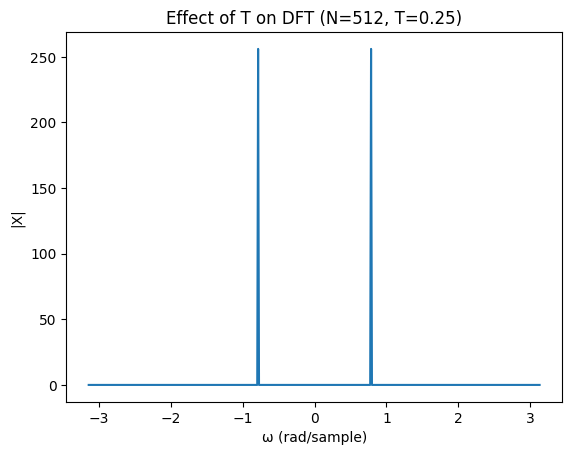

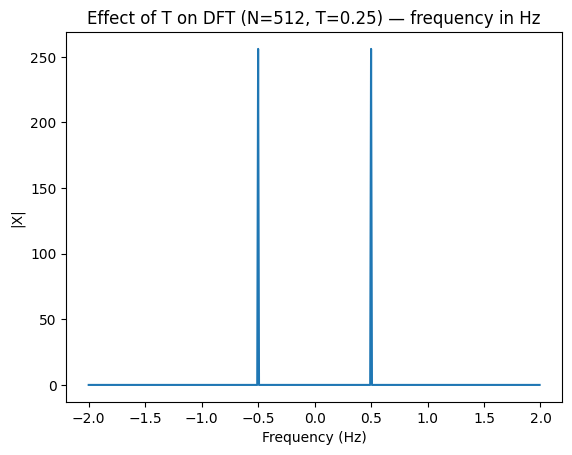

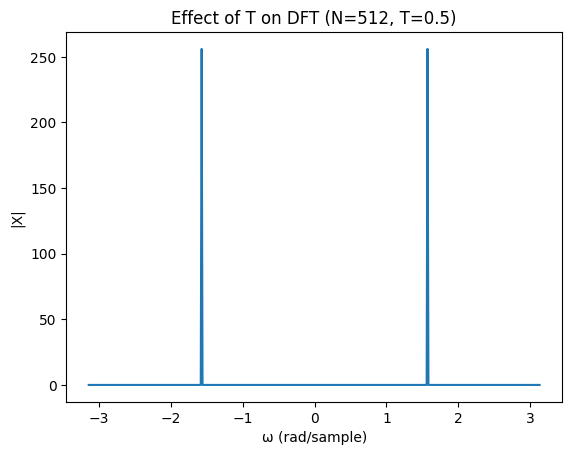

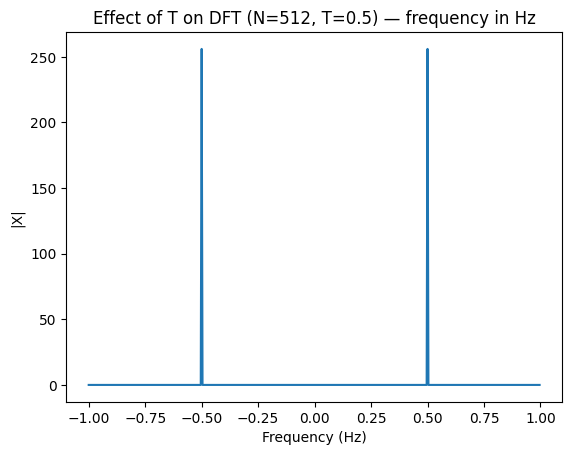

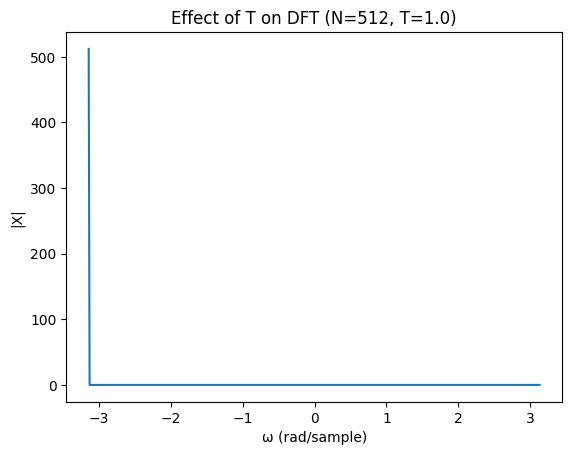

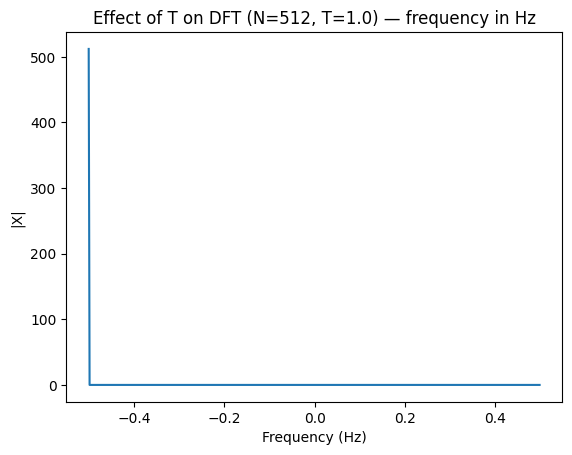

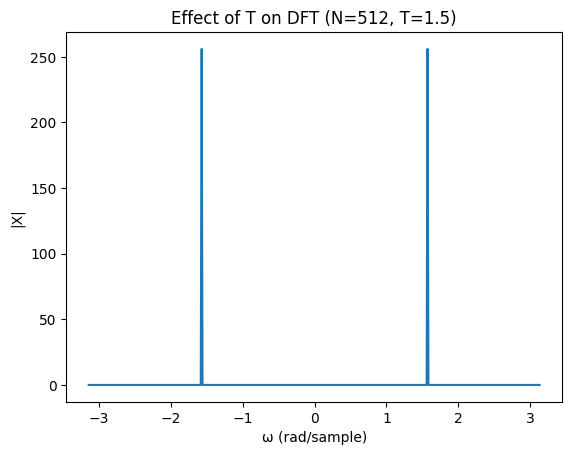

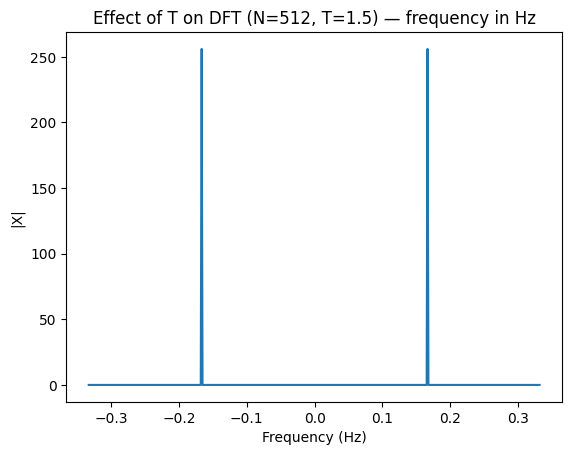

In [93]:
N_fix = 512
n_fix = np.arange(-N_fix//2, N_fix//2)
for T2 in [0.25, 0.5, 1.0, 1.5]:
    xT = np.cos(np.pi * (n_fix*T2))
    XT = fft(xT)
    XTc = np.fft.fftshift(XT)
    wT = np.linspace(-np.pi, np.pi, N_fix, endpoint=False)
    f_axis_T = (wT/(2*np.pi)) * (1.0/T2)
    plt.figure()
    plt.plot(wT, np.abs(XTc))
    plt.xlabel("ω (rad/sample)")
    plt.ylabel("|X|")
    plt.title(f"Effect of T on DFT (N={N_fix}, T={T2})")
    plt.show()

    plt.figure()
    plt.plot(f_axis_T, np.abs(XTc))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|X|")
    plt.title(f"Effect of T on DFT (N={N_fix}, T={T2}) — frequency in Hz")
    plt.show()

**Takeaways**

* Increasing **$N$** improves **frequency resolution** ($\Delta f=F_s/N$) and scales the peak height $\propto N$ with this normalization; locations do not move.
* Changing **$T$** (thus $F_s$) moves the peaks on the **$\omega$** axis via $\omega_0=\pi T$ and determines whether, in Hz, you see the **true frequency** ($T\le 1$) or an **aliased** one ($T>1$).
* The special case $T=1$ lands at **Nyquist**, where the two conjugate DFT lines **merge** into a single bin.